**CONSIGNAS PARA TODOS LOS EJERCICIOS:**

1.   En el caso de utilizar una Regresión Logística grafique sus parámetros con la función AA_utils.visualizar_parametros
2.   Grafique e interprete la matriz de confusión de la predicción sobre el set de test con la función AA_utils.visualizar_confusion_matrix
3.   Elabore un reporte de métricas tanto para la predicción de train como para la de test con la función AA_utils.print_classification_report
4.   En los casos de clasificación binaria grafique e interprete la curva ROC con la función AA_utils.visualizar_curva_ROC
5.   En los caso de clasificación de dos variables grafique la función de transferencia y la frontera de decisión con las funciones AA_utils.visualizar_funcion_transferencia_2D y AA_utils.visualizar_frontera_de_desicion_2D
6.   En los casos de clasificación binaria de una variable grafique la curva logística con la función AA_utils.visualizar_curva_logistica

# **IRIS**

**Clasificación Multiclase:** Compare modelos de Regresión Logística y Redes Neuronales para clasificar el dataset Iris.csv. El dataset contiene información de 3 especies de flores. 

El código “ejemplo_clasificacion_multiclase_dos_variables_regresion_logistica.py” posee un ejemplo de cómo realizar una clasificación multiclase.


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# **AA UTILS**

In [95]:
def if_dataframe_to_numpy(data):
    return data.to_numpy() if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series) else data

def plot_2d(modelo, X, X_train, X_test, y_train, y_test, boundry_function):

    assert X.shape[1] == 2, f"X debe tener solo dos variables de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)
    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    plt.figure()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = np.c_[xx.ravel(), yy.ravel()]
    Z = boundry_function(modelo, Z)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.colorbar()

    plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, label='Training')
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="+", c=y_test, s=80, label='Testing')
    plt.legend()
    plt.show()

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

def visualizar_parametros(modelo, mostrar_bias, feature_names=[], target_name='target'):
    parametros = pd.DataFrame(modelo.coef_, columns=feature_names if len(feature_names) > 0 else range(modelo.coef_.shape[1]))

    if mostrar_bias:
        parametros['bias'] = modelo.intercept_

    parametros.T.plot(kind='bar')

    if hasattr(modelo, 'classes_'):
        if len(modelo.classes_) <= 2:
            plt.legend([target_name])
        else:
            plt.legend(list(modelo.classes_))
    else:
        plt.legend([target_name])

    plt.show()

def visualizar_curva_logistica(modelo, X, y, feature_name='target'):

    assert X.shape[1] == 1, f"X debe tener solo una variable de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)

    plt.figure()
    plt.scatter(X, y, c=y, s=50)
    plt.xlabel(feature_name)
    plt.grid()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_graph = np.linspace(x_min, x_max)
    y_graph = modelo.predict_proba(x_graph.reshape(-1, 1))[:, 1]
    plt.plot(x_graph, y_graph)
    plt.show()

def visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test):
    plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict(Z))

def visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test):

    if hasattr(modelo, 'predict_proba') and callable(getattr(modelo, 'predict_proba')):
        plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict_proba(Z)[:, 1])
    else:
        raise ValueError("no se puede visualizar funcion de transferencia")

def visualizar_confusion_matrix(real_target, pred_target,
                                classes=[],
                                normalize=False,
                                title='Matriz de confusión',
                                cmap=plt.cm.Blues):

    if (len(classes) == 0):
        classes = [str(i) for i in range(int(max(real_target) + 1))]  # nombres de clases consecutivos

    cm = confusion_matrix(real_target, pred_target)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def visualizar_curva_ROC(modelo, X, y):

    assert len(set(y)) <= 2, f"El dataset debe ser binario (hay {len(set(y))}) clases"

    y_score = modelo.predict_proba(X)[:, 1]  # se queda con la clase 1

    false_positive_rate, true_positive_rate, threshold = roc_curve(y, y_score)

    precision, recall, _ = precision_recall_curve(y, y_score)

    # ROC
    plt.figure()
    plt.title('ROC. Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (1- Especificidad)')
    plt.show()

    # precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()

def elegir_imagen_al_azar(X, pixeles_ancho, pixeles_alto):
    indice = np.random.randint(0, X.shape[0])
    img_i = np.reshape(X[indice, :], (pixeles_ancho, pixeles_alto))
    plt.figure()
    plt.imshow(img_i, 'gray')
    plt.title('Dato aleatorio')
    plt.show()
    return X[indice].reshape(1, -1), indice

def visualizar_parametros_para_imagenes(modelo, cantidad_de_clases, pixeles_ancho=28, pixeles_alto=28):

    if hasattr(modelo, 'coef_'):
        w = modelo.coef_
    elif hasattr(modelo, 'coefs_') and (modelo.coefs_) == 1:
        w = modelo.coefs_[0]
    else:
        raise "para visualizar los parametros de la red es necesario tener cero capas ocultas"

    colorbar_max = np.abs(np.max(w))
    w_r = np.reshape(w, (cantidad_de_clases, pixeles_ancho, pixeles_alto))
    fig, ax = plt.subplots(2, cantidad_de_clases // 2)
    plt.suptitle('Coeficientes aprendidos para cada clase, \nagrupados en forma matricial de 28x28')
    index = 0
    for row in range(0, 2):
        for col in range(0, cantidad_de_clases // 2):
            colorbar_max = max(np.abs(np.max(w_r[index, :, :])), np.abs(np.min(w_r[index, :, :])))
            ax_im = ax[row][col].imshow(w_r[index, :, :], cmap='seismic', vmin=-colorbar_max, vmax=colorbar_max)
            ax[row][col].get_xaxis().set_visible(False)
            ax[row][col].get_yaxis().set_visible(False)
            ax[row][col].set_title(str(index))
            divider = make_axes_locatable(ax[row][col])
            cax = divider.append_axes("right", size="5%", pad=0.05)

            fig.colorbar(ax_im, ax=ax[row][col], cax=cax)
            index += 1
    plt.show()

def visualizar_ajuste_por_regresion(modelo, X_train, X_test, y_train, y_test,
                                    feature_name='X', target_name='target'):
    plt.scatter(X_train, y_train, c='blue', s=40, alpha=0.9, label='Training')
    plt.scatter(X_test, y_test, c='red', s=50, alpha=0.5, label='Testing')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.legend()
    plt.grid()

    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    x_max = max(max(X_train), max(X_test))
    x_min = min(min(X_train), min(X_test))

    x_plot = np.linspace(x_min, x_max, 100)
    y_plot = modelo.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, 'g--', linewidth=5)
    plt.show()

def visualizar_curva_error_entrenamiento(modelo):
    plt.plot(modelo.loss_curve_)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Train'])
    plt.show()


# **CLASIFICACIÓN MULTICLASE**

**CARGA DE DATOS**

In [96]:
df = pd.read_csv(r"https://raw.githubusercontent.com/KevinFDI/IML_Practica_3/main/Pr%C3%A1ctica/datasets/iris.csv")

In [97]:
pd.DataFrame(df)

,sepal_length,sepal_width,petal_length,petal_width,name
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Convierto los valores de la columna "name" por int para realizar la clasificacion multiclase (si no realizo este paso, no puedo graficar por ejemplo la matriz de confusión).

In [98]:
data = df.replace({'setosa' : 1, 'virginica' : 2, 'versicolor' : 3})

**PREPROCESADO**

In [99]:
X = data.drop(columns=['name'])
y = data['name']

print(f'''
      ====================================================================================================
      El problema de clasificación es de {X.shape[1]} features ---(prediciendo)---> {len(set(y))} clases
      ====================================================================================================
      ''')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NORMALIZAR = True

if NORMALIZAR:
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


      El problema de clasificación es de 4 features ---(prediciendo)---> 3 clases
      


# **REGRESIÓN LOGÍSTICA - CLASIFICACIÓN MULTICLASE**

**MODELADO**

In [100]:
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

LogisticRegression()

**EVALUACION**

**MÉTRICAS SOBRE EL CONJUNTO DE TRAINING**

In [101]:
# 3

print_classification_report(y_train, modelo.predict(X_train))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        40
           2       0.93      0.97      0.95        38
           3       0.97      0.93      0.95        42

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



**MÉTRICAS SOBRE EL CONJUNTO DE TESTING**

In [102]:
# 3

print_classification_report(y_test, modelo.predict(X_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         8

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



El punto #4 no aplica por ser una clasificación multiclase.

**MATRIZ DE CONFUSIÓN**

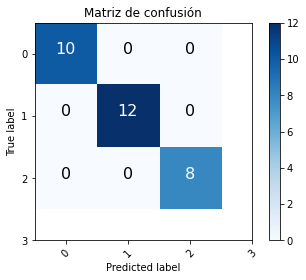

In [103]:
# 2

visualizar_confusion_matrix(y_test, modelo.predict(X_test))

Se observa un modelo balanceado con pocas variables clasificadas como False Positive y Negative.

**VISUALIZACION DE PARÁMETROS**

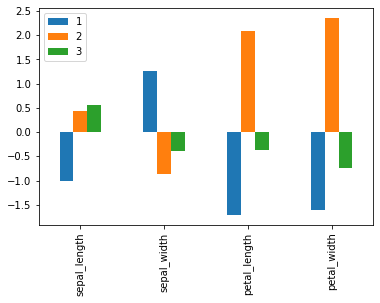

In [104]:
# 1

visualizar_parametros(modelo, mostrar_bias=False, feature_names=X.columns, target_name=y.name)

**FRONTERA DE DECISIÓN DE DOS DIMENSIONES**

El punto 5 no aplica para clasificación multiclase.

**FUNCION DE TRANSFERENCIA DE DOS DIMENSIONES**

El punto 5 no aplica para clasificación multiclase.

La **curva logística** del punto #6 con la función AA_utils.visualizar_curva_logistica no aplica en este ejercicio debido a que el modelo cuenta con mas de una features en la variable X.

# **REDES NEURONALES**

**MODELADO**

In [105]:
modelo_2 = MLPClassifier(hidden_layer_sizes=(20, 5),
                       max_iter=500,
                       tol=1e-4,
                       verbose=True,
                       activation='tanh',
                       learning_rate_init=0.003,
                       solver='adam')
modelo_2.fit(X_train, y_train)

Iteration 1, loss = 1.30233323
Iteration 2, loss = 1.24400768
Iteration 3, loss = 1.18813065
Iteration 4, loss = 1.13481450
Iteration 5, loss = 1.08417783
Iteration 6, loss = 1.03632700
Iteration 7, loss = 0.99131137
Iteration 8, loss = 0.94912670
Iteration 9, loss = 0.90972704
Iteration 10, loss = 0.87303316
Iteration 11, loss = 0.83893792
Iteration 12, loss = 0.80731259
Iteration 13, loss = 0.77801400
Iteration 14, loss = 0.75089127
Iteration 15, loss = 0.72579114
Iteration 16, loss = 0.70256202
Iteration 17, loss = 0.68105668
Iteration 18, loss = 0.66113395
Iteration 19, loss = 0.64265979
Iteration 20, loss = 0.62550778
Iteration 21, loss = 0.60955966
Iteration 22, loss = 0.59470553
Iteration 23, loss = 0.58084402
Iteration 24, loss = 0.56788217
Iteration 25, loss = 0.55573518
Iteration 26, loss = 0.54432604
Iteration 27, loss = 0.53358510
Iteration 28, loss = 0.52344955
Iteration 29, loss = 0.51386300
Iteration 30, loss = 0.50477492
Iteration 31, loss = 0.49614018
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 5),
              learning_rate_init=0.003, max_iter=500, verbose=True)

**EVALUACION**

**MÉTRICAS SOBRE EL CONJUNTO DE TRAINING**

In [106]:
# 3

print_classification_report(y_train, modelo_2.predict(X_train))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        40
           2       0.97      0.97      0.97        38
           3       0.98      0.98      0.98        42

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



**MÉTRICAS SOBRE EL CONJUNTO DE TESTING**

In [107]:
# 3

print_classification_report(y_test, modelo_2.predict(X_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         8

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



**MATRIZ DE CONFUSIÓN**

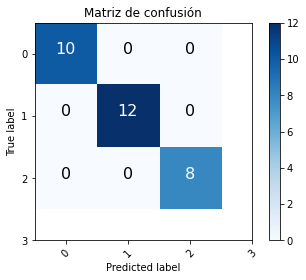

In [108]:
# 2

visualizar_confusion_matrix(y_test, modelo_2.predict(X_test))

A diferencia del otro modelo, en éste directamente no hay valores clasificados como Falsos Positivos o Negativos.

**CURVA DE ROC Y DE PRECISION-RECALL**

El punto #4 no aplica por ser una clasificación multiclase.

**FRONTERA DE DECISIÓN DE DOS DIMENSIONES**

El punto 5 no aplica para clasificación multiclase.

**FUNCION DE TRANSFERENCIA DE DOS DIMENSIONES**

El punto 5 no aplica para clasificación multiclase.

**CURVA DE ERROR DE ENTRENAMIENTO**

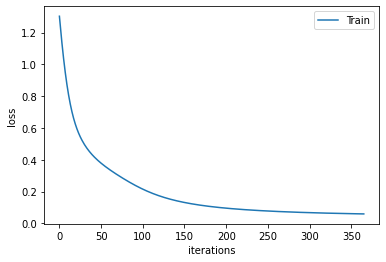

In [109]:
visualizar_curva_error_entrenamiento(modelo_2)

La **curva logística** del punto #6 con la función AA_utils.visualizar_curva_logistica no aplica en este ejercicio debido a que el modelo cuenta con mas de una features en la variable X.